# Dirichlet-Multinomial Distribution

This notebook is about the [Dirichlet-Multinomial distribution](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution). This distribution has a wide ranging array of applications to modelling categorical variables. It has found its way into machine learning areas such as topic modeling and Bayesian Belief networks. The Dirichlet-Multinomial probability mass function is defined as follows.

$\Pr(\mathbf{x}\mid\boldsymbol{\alpha})=\frac{\left(n!\right)\Gamma\left(\alpha_0\right)}
{\Gamma\left(n+\alpha_0\right)}\prod_{k=1}^K\frac{\Gamma(x_{k}+\alpha_{k})}{\left(x_{k}!\right)\Gamma(\alpha_{k})}$

where

* $x_k$ is the k-th count
* $n = \sum_k x_k$
* $\alpha_k$ is a prior belief about the k-th count
* $\alpha_0 = \sum_k \alpha_k$
* $\Gamma$ is the gamma function, defined as $\Gamma(x) = (x -1)!$

To make this distribution easier to understand, let's imagine an unfair die ([die](https://www.grammarly.com/blog/dice-die/) is the singular form of dice). Let's remember that a die has 6 sides. Now, with this 6-sided die, we roll it 100 times and observe the number of times a 1, 2, 3, 4, 5, and 6 came up.

* 1: 10
* 2: 20
* 3: 30
* 4: 15
* 5: 10
* 6: 15

We can model the probability distribution of these numbers using a Multinomial distribution, which is defined as follows.

$f(x_1,\ldots,x_k;p_1,\ldots,p_k) = \frac{n!}{x_1!\cdots x_k!} p_1^{x_1} \cdots p_k^{x_k}$

where

* $x_1$ is the k-th count
* $n = \sum_k x_k$
* $p_k$ is the k-th probability corresonding to the k-th count

Note the factorials? We can re-express the Multinomial distribution using the $\Gamma$ function.

$f(x_1,\dots, x_{k}; p_1,\ldots, p_k) = \frac{\Gamma(\sum_i x_i + 1)}{\prod_i \Gamma(x_i+1)} \prod_{i=1}^k p_i^{x_i}$

But how does the Dirichlet distribution fit it? The Dirichlet distribution is used with the Multinomial when we consider a Bayesian approach to modeling the distribution. In simple words, the probabilities $p_1, \ldots, p_k$ are the parameters of the counts $x_1, \ldots, x_k$, and the priors $\alpha_1, \ldots, \alpha_k$ are the parameters of the probabilities. The priors $\alpha$ are called the hyperparameters (parameters of other parameters), and probabilities are called the parameters. The counts are generated by a multinomial distribution, and the multinomial distribution probabilities $p_k$'s are generated by a Dirichlet distribution.

The Dirichlet distribution is defined as follows.

$f \left(p_1,\ldots, p_{K}; \alpha_1,\ldots, \alpha_K \right) = \frac{1}{\mathrm{B}(\boldsymbol\alpha)} \prod_{i=1}^K p_i^{\alpha_i - 1}$

where

* $\mathrm{B}(\boldsymbol\alpha) = \frac{\prod_{i=1}^K \Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^K \alpha_i\right)}$

[Just trust me](https://vangjee.wordpress.com/2012/12/12/bayesian-scoring-functions-for-structure-learning-of-bayesian-belief-networks-bbns/) that you can combine the Dirichlet with the Multinomial to get the final expression below.

$f(x_1,\ldots,x_k;\alpha_1,\ldots,\alpha_k) = \frac{\left(n!\right)\Gamma\left(\alpha_0\right)}{\Gamma\left(n+\alpha_0\right)}\prod_{k=1}^K\frac{\Gamma(x_{k}+\alpha_{k})}{\left(x_{k}!\right)\Gamma(\alpha_{k})}$

This notebook shows how you can code up all the distributions and functions involved with Dirichlet-Multinomial distribution. It also shows how you can use the distribution to compute the log-probability of the data as well as sample data from the distribution.

## Functions and distributions

Below are the code to express the functions and distributions.

* The factorial function computes $x!$. However, for large $x$, the evaluation will lead to overflow, and so we use Stirling's approximation. 
* The gamma function $\Gamma(x)$ uses the factorial function.
* The beta function $\mathrm{B}(\alpha_1, \ldots, \alpha_K)$ uses the gamma function.
* The gamma distribution (note there is the gamma function, above, and this one, the gamma distribution) $\Gamma(x; \alpha, \beta)$ is usde by the Dirichlet distribution. As you can see, there are 2 parameters $\alpha$ and $\beta$, but our implementation below only considers $\alpha$ with $\beta$ assumed to be 1. Also note that in general, $\alpha$ and $\beta$ can take on values other than integers; in this implementation, we only consider whole numbers (I think the program might [aslpode](http://www.yourdictionary.com/asplode) if you put in floats).
* The Dirichlet-Multinomial distribution uses the Dirichlet and Multinomial distributions.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

np.random.seed(37)

def factorial(x):
    if x <= 0.0:
        return 1
    
    # typically stirling's approximation would be (x / e)^x
    # for large values of x, this creates an overflow
    # we use 1 here, which doesn't seem to affect the sampling or probability estimations
    g = np.sqrt(2 * np.pi * x) * np.power(x / 2.718281, 1)
    return g

def gamma(n):
    return factorial(n - 1)

def beta(alphas):
    k = len(alphas)
    b = 1.
    for i in range(k):
        b *= gamma(alphas[i])
    b = b / gamma(np.sum(alphas))
    return b

def rgama(a):
    d = a - 1. / 3.
    c = 1. / np.sqrt(9. * d)
    
    while True:
        x = None
        v = -1
        
        while v <= 0:
            x = np.random.normal(0, 1)
            v = 1. + c * x
            
        v = np.power(v, 3)
        u = np.random.uniform()
        
        if u < 1 - 0.0331 * (x * x) * (x * x):
            return d * v
        
        if np.log(u) < 0.5 * x * x + d * (1 - v + np.log(v)):
            return d * v

def dgama(x, alpha):
    d = np.log(np.power(x, alpha - 1)) + np.log(2.718281) - np.log(gamma(alpha))
    return d

def rdirch(alphas):
    k = len(alphas)
    x = np.array([rgama(alphas[i]) for i in range(k)])
    total = np.sum(x)
    x = [s / total for s in x]
    return x

def ddirch(x, alphas):
    k = len(x)
    d = 0.
    for i in range(k):
        d += np.log(np.power(x[i], alphas[i] - 1))
    d -= np.log(1. / beta(alphas))
    return d

def rmultnomial(p):
    k = len(p)
    probs = [prob / np.sum(p) for prob in p]
    x = np.random.uniform()
    cummulative_p = 0
    for i, prob in enumerate(probs):
        cummulative_p += prob
        if cummulative_p - x >= 0:
            return i
    return k - 1

def dmultinomial(x, p):
    k = len(x)
    d = np.log(gamma(np.sum(x + 1)))
    for i in range(k):
        d += np.log(np.power(p[i], x[i]))
    for i in range(k):
        d -= np.log(gamma(x[i] + 1))
    return d

def rdirmultinom(alphas):
    p = rdirch(alphas)
    m = rmultnomial(p)
    return m

def ddirmultinom(x, alphas):
    k = len(x)
    n = np.sum(x)
    sum_alphas = np.sum(alphas)
    
    d = np.log(factorial(n))
    d += np.log(gamma(sum_alphas))
    d -= np.log(gamma(n + sum_alphas))
    
    for i in range(k):
        d += np.log(gamma(x[i] + alphas[i]))
        d -= np.log(factorial(x[i]))
        d -= np.log(gamma(alphas[i]))
        
    return d

## Gamma

Here, we sample 1 point from the $\Gamma(\alpha=1)$ distribution. Then we evaluate the probability of that sample point with $\Gamma$ distributions parameterized differently. As you can see, $P(x | \Gamma(\alpha=1))$ is the highest (log-probability).

In [2]:
import pandas as pd

x = rgama(1)

print(f'estimating probability of {x:.5f}')

pd.DataFrame(
    [(alpha + 1, dgama(x, alpha + 1)) for alpha in range(5)], 
    columns=['alpha', 'probability'])

estimating probability of 0.62318


,alpha,probability
0,1,1.000000
1,2,0.608139
2,3,-0.904504
3,4,-1.985623
4,5,-2.890068


Here we make 1,000 samples from gamma distributions parameterized differently and plot the density curves.

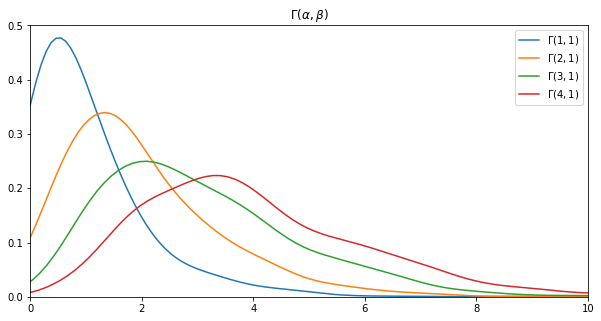

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 10])
ax.set_title(r'$\Gamma(\alpha, \beta)$')

sns.kdeplot([rgama(1) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(1, 1)$')
sns.kdeplot([rgama(2) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(2, 1)$')
sns.kdeplot([rgama(3) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(3, 1)$')
sns.kdeplot([rgama(4) for _ in range(1000)], bw=0.5, ax=ax, label=r'$\Gamma(4, 1)$')

## Dirichlet

Here we sample 1 set of probabilities from a Dirichlet distribution with the $\alpha$'s as $\mathrm{\alpha} = [\alpha_1, \alpha_2] = [1, 2]$. We then estimate the (log) probability of these probabilities for two Dirichlet distribution parameterized differently.

In [4]:
alphas = np.array([1, 2])
x = rdirch(alphas)

params = [
    np.array([1, 2]),
    np.array([1, 3]),
    np.array([5, 5]),
    np.array([5, 1])
]
print(f'estimating the probability of {x}')

pd.DataFrame([(p, ddirch(x, p)) for p in params], columns=['alphas', 'probability'])

estimating the probability of [0.8011123776705179, 0.198887622329482]


,alphas,probability
0,"[1, 2]",-2.654736
1,"[1, 3]",-3.838228
2,"[5, 5]",-6.565092
3,"[5, 1]",-1.221732


Here we sample data points from two Dirichlet distributions and plot the density of the samples.

* $\operatorname{Dir}(\alpha_1=1, \alpha_2=2)$
* $\operatorname{Dir}(\alpha_1=9, \alpha_2=1)$

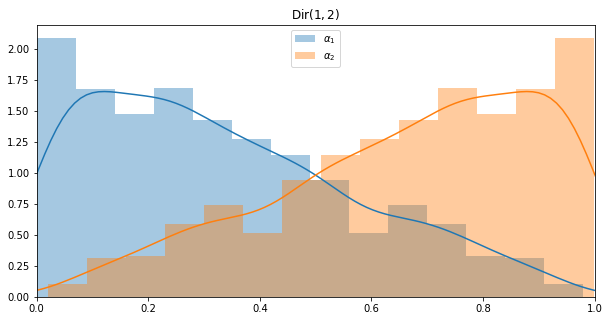

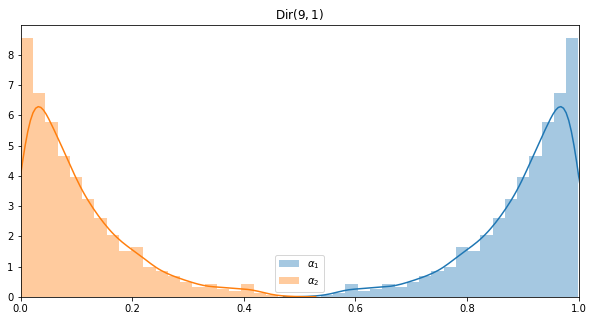

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 1])
ax.set_title(r'$\operatorname{Dir}(1, 2)$')
x = np.array([rdirch(np.array([1, 2])) for _ in range(1000)])
sns.distplot(x[:, 0], ax=ax, label=r'$\alpha_1$')
sns.distplot(x[:, 1], ax=ax, label=r'$\alpha_2$')
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim([0, 1])
ax.set_title(r'$\operatorname{Dir}(9, 1)$')
x = np.array([rdirch(np.array([9, 1])) for _ in range(1000)])
sns.distplot(x[:, 0], ax=ax, label=r'$\alpha_1$')
sns.distplot(x[:, 1], ax=ax, label=r'$\alpha_2$')
plt.legend()

## Multinomial

Here we sample from the Multinomial distribution using different parameters. One of these sampling is for the die example at the beggining.

In [6]:
num_ones = 0
for i in range(1000):
    v = rmultnomial(np.array([0.1, 0.9]))
    if v == 1:
        num_ones += 1
        
print('k = 2, p = [0.1, 0.9]')
print(num_ones / 1000.)

num_zeros = 0
num_ones = 0
num_twos = 0

for i in range(1000):
    v = rmultnomial(np.array([0.1, 0.8, 0.1]))
    if v == 0:
        num_zeros += 1
    elif v == 1:
        num_ones += 1
    else:
        num_twos += 1

print('')
print('k = 3, p = [0.1, 0.8, 0.1]')
print(num_zeros / 1000.)
print(num_ones / 1000.)
print(num_twos / 1000.)

die_counts = np.zeros(6)
for i in range(1000):
    v = rmultnomial(np.array([0.10, 0.2, 0.3, 0.15, 0.10, 0.15]))
    die_counts[v] += 1
sum_counts = np.sum(die_counts)
die_counts = [c / sum_counts for c in die_counts]
print('')
print('k = 6, p = [0.1, 0.2, 0.3, 0.15, 0.10, 0.15], rolling a die')
for i, p in enumerate(die_counts):
    print('{}: {}'.format(i+1, p))

k = 2, p = [0.1, 0.9]
0.895

k = 3, p = [0.1, 0.8, 0.1]
0.106
0.793
0.101

k = 6, p = [0.1, 0.2, 0.3, 0.15, 0.10, 0.15], rolling a die
1: 0.083
2: 0.197
3: 0.31
4: 0.147
5: 0.079
6: 0.184


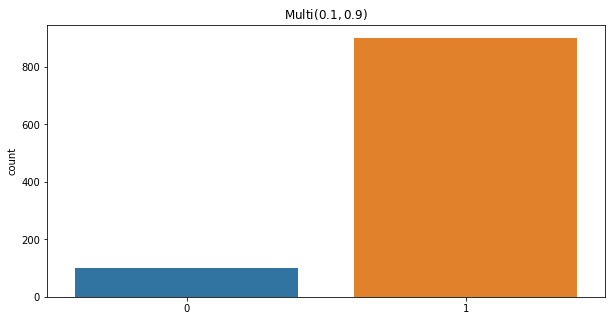

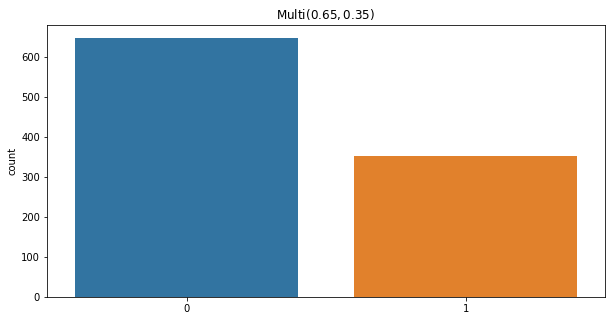

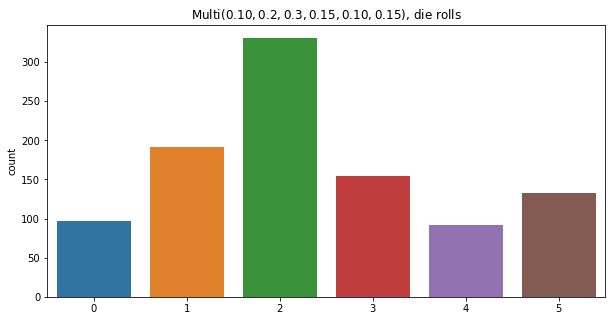

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{Multi}(0.1, 0.9)$')
x = np.array([rmultnomial(np.array([0.1, 0.9])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{Multi}(0.65, 0.35)$')
x = np.array([rmultnomial(np.array([0.65, 0.35])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{Multi}(0.10, 0.2, 0.3, 0.15, 0.10, 0.15)$, die rolls')
x = np.array([rmultnomial(np.array([0.10, 0.2, 0.3, 0.15, 0.10, 0.15])) for _ in range(1000)])
sns.countplot(x)

Now we estimate log probability of a sample for Multinomial distributions parameterized differently.

In [8]:
import warnings

with warnings.catch_warnings(record=True):
    sample = np.array([2, 8])
    params = [np.array([p, 1.0 - p]) for p in np.linspace(0, 1, 11)]
    sparams = ['[' + ', '.join(['{:.3f}'.format(i) for i in p]) + ']' for p in params]

    df = pd.DataFrame([(s, dmultinomial(sample, p)) for p, s in zip(params, sparams)], 
        columns=['parameters', 'probability'])
df

,parameters,probability
0,"[0.000, 1.000]",-inf
1,"[0.100, 0.900]",-5.929033
2,"[0.200, 0.800]",-5.485003
3,"[0.300, 0.700]",-5.742324
4,"[0.400, 0.600]",-6.400165
5,"[0.500, 0.500]",-7.412451
6,"[0.600, 0.400]",-8.832956
7,"[0.700, 0.300]",-10.826111
8,"[0.800, 0.200]",-13.802769
9,"[0.900, 0.100]",-19.112381


## Dirichlet-multinomial

Here's the last example of sampling from a Dirichlet-Multinomial distribution and then estimating the probality of observed counts using the Dirichlet-Multinomial distributions parameterized differently.

In [9]:
count_0 = 0
count_1 = 0

for i in range(100):
    v = rdirmultinom(np.array([2, 8]))
    if v == 0:
        count_0 += 1
    else:
        count_1 += 1

print('estimating probability of count_0 = {}, count_1 = {}'.format(count_0, count_1))

sample = np.array([count_0, count_1])
params = [np.array([alpha_0, 10.0 - alpha_0]) for alpha_0 in np.linspace(0, 10, 11)]

pd.DataFrame([(p, ddirmultinom(sample, p)) for p in params], 
             columns=['alphas', 'probability'])

estimating probability of count_0 = 17, count_1 = 83


,alphas,probability
0,"[0.0, 10.0]",-0.065782
1,"[1.0, 9.0]",0.185436
2,"[2.0, 8.0]",0.535957
3,"[3.0, 7.0]",-0.208196
4,"[4.0, 6.0]",-0.482921
5,"[5.0, 5.0]",-0.523687
6,"[6.0, 4.0]",-0.374440
7,"[7.0, 3.0]",0.009409
8,"[8.0, 2.0]",0.863991
9,"[9.0, 1.0]",0.625902


Finally, we sample from a Dirichlet-Multinomial distribution and plot the observed counts.

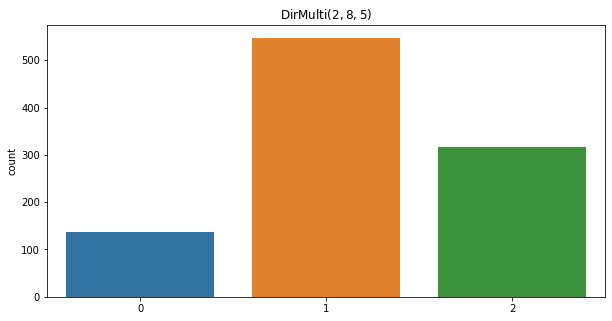

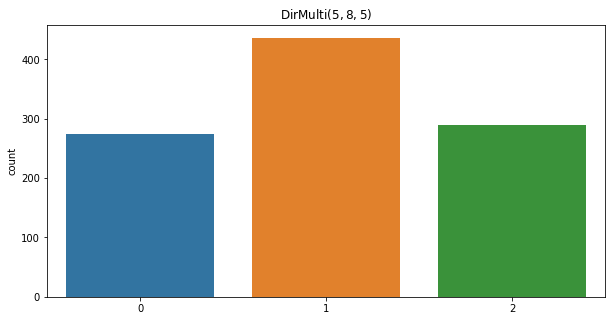

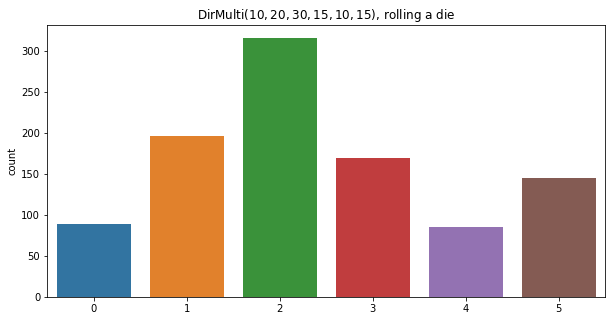

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{DirMulti}(2, 8, 5)$')
x = np.array([rdirmultinom(np.array([2, 8, 5])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{DirMulti}(5, 8, 5)$')
x = np.array([rdirmultinom(np.array([5, 8, 5])) for _ in range(1000)])
sns.countplot(x)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(r'$\operatorname{DirMulti}(10, 20, 30, 15, 10, 15)$, rolling a die')
x = np.array([rdirmultinom(np.array([10, 20, 30, 15, 10, 15])) for _ in range(1000)])
sns.countplot(x)